Earliest conflicting flight: 4.0 on aircraft idx 2
Aircraft A320#1 has 0.05 probability of breaking down at 2024-09-14 07:26:00.151213 until 2024-09-14 08:26:00.151213
Aircraft A320#3 has 0.71 probability of breaking down at 2024-09-14 18:43:07.233480 until 2024-09-14 19:43:07.233480
State space shape: (4, 41)
Earliest conflicting flight: 4.0 on aircraft idx 2
Aircraft A320#1 has 0.71 probability of breaking down at 2024-09-14 19:13:46.584036 until 2024-09-14 20:13:46.584036
Aircraft A320#3 has 0.55 probability of breaking down at 2024-09-14 12:10:35.355518 until 2024-09-14 13:10:35.355518
State space shape: (4, 41)
Observation shape: (1, 328)
Step 0:
Flights Dict:
{1: {'Orig': 'CDG', 'Dest': 'FRA', 'DepTime': '07:45', 'ArrTime': '10:00', 'PrevFlight': 0}, 2: {'Orig': 'DUB', 'Dest': 'TXL', 'DepTime': '10:07', 'ArrTime': '11:43', 'PrevFlight': 0}, 3: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '14:05', 'ArrTime': '17:07', 'PrevFlight': 0}, 4: {'Orig': 'FRA', 'Dest': 'IST', 'DepTime': '10:

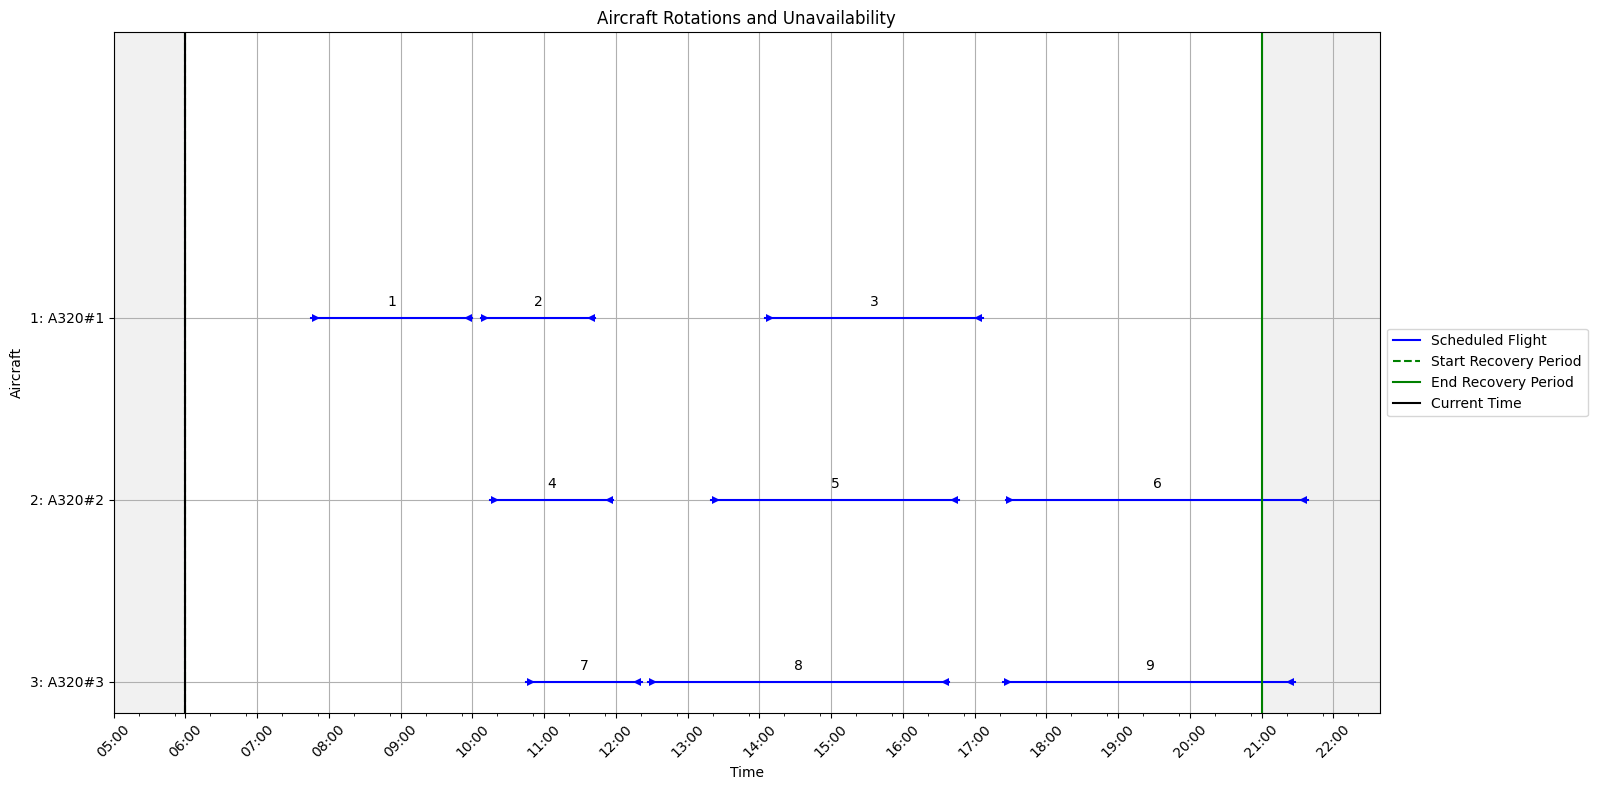

[[2 4 0 900 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [1 nan nan 1 86 1 105 240 2 247 343 3 485 667 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [2 23 737 0 nan 4 255 358 5 440 647 6 686 939 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [3 nan nan 0 nan 7 285 382 8 387 639 9 684 928 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]]

Processed action: 0 of type: <class 'numpy.int64'>
Current conflicts: {('A320#2', 255.0, 358.0), ('A320#2', 686.0, 939.0), ('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Earliest conflicting flight: 4.0 on aircraft idx 2
Current conflicts: {('A320#2', 255.0, 358.0), ('A320#2', 686.0, 939.0), ('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Curr

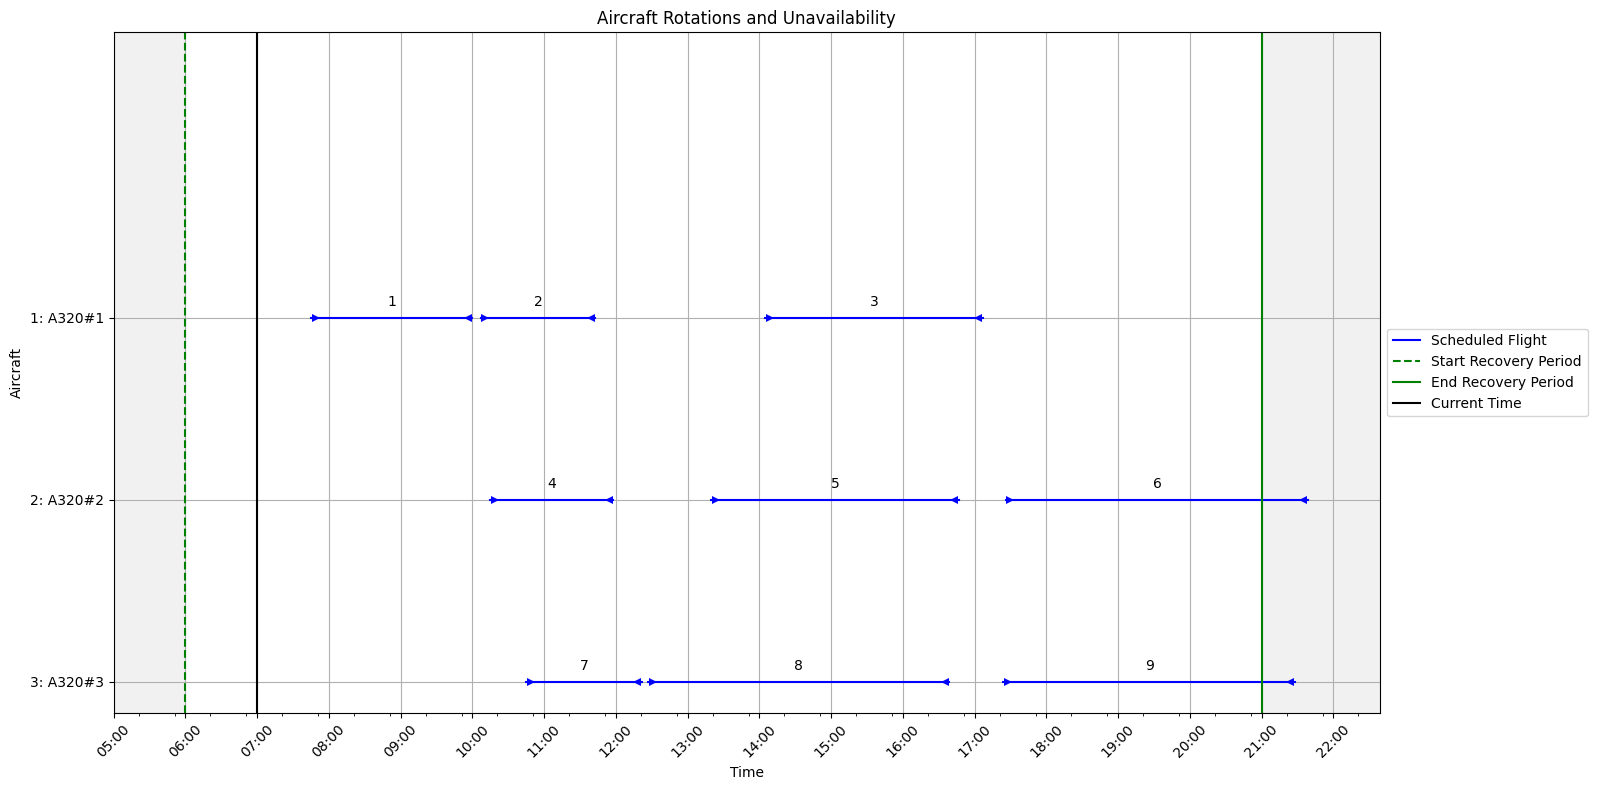

[[2 4 60 840 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [1 nan nan 0 nan 1 105 240 2 247 343 3 485 667 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [2 23 737 0 nan 4 255 358 5 440 647 6 686 939 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [3 nan nan 0 nan 7 285 382 8 387 639 9 684 928 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]]

Processed action: 2 of type: <class 'numpy.int64'>
Current conflicts: {('A320#2', 255.0, 358.0), ('A320#2', 686.0, 939.0), ('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Updating flight times for flight 4.0
 - previous times: 10:15 11:58
 - new times: 18:17 20:00
Updating flight times for flight 6.0
 - previous times: 17:26 21:39
 - new times: 

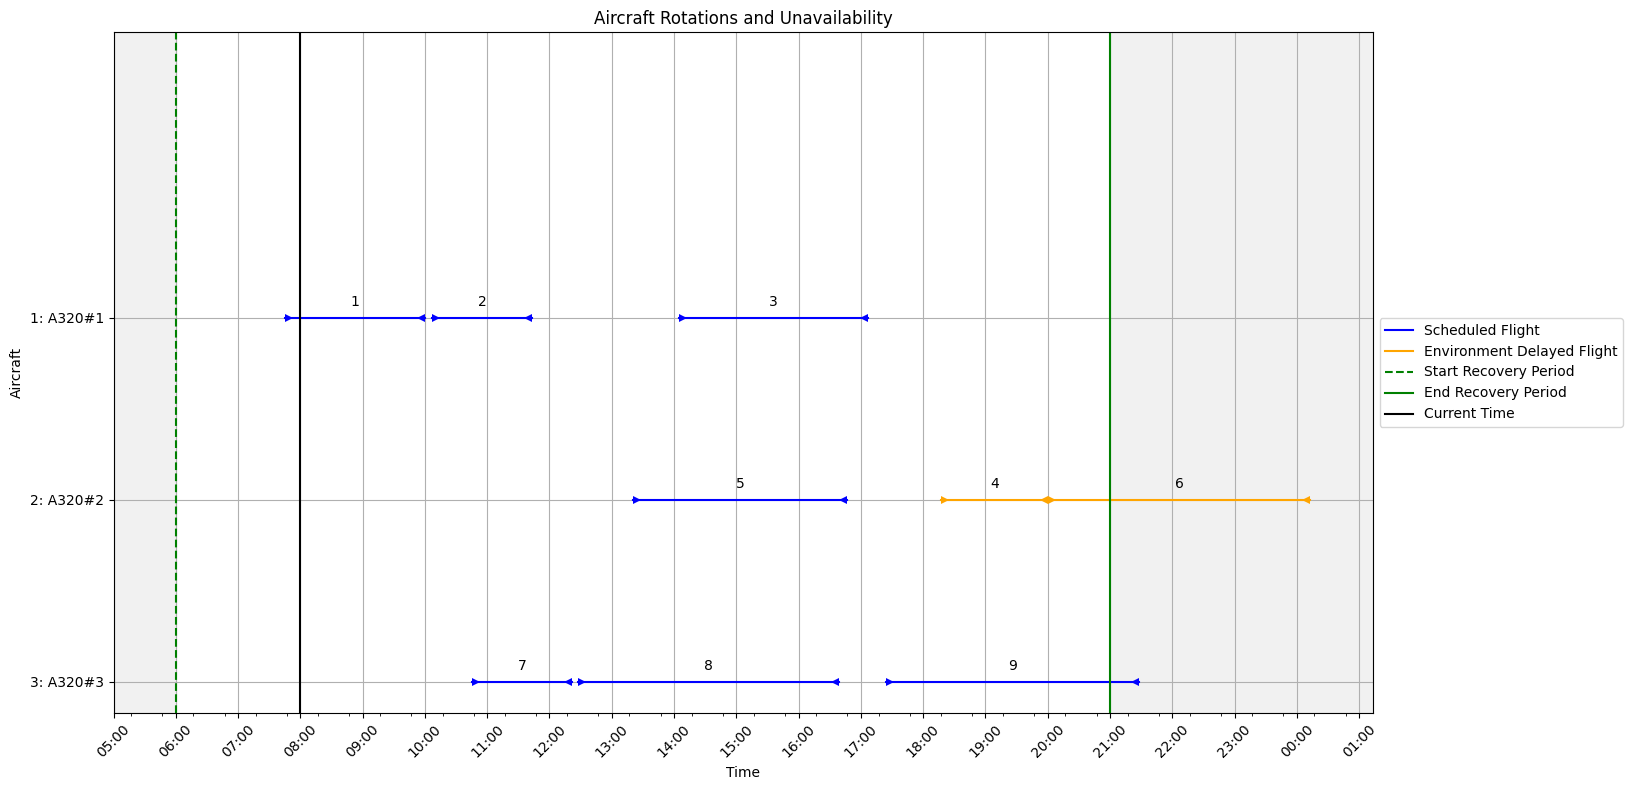

[[2 5 120 780 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [1 nan nan 0 nan 1 105 240 2 247 343 3 485 667 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [2 23 737 0 nan 5 440 647 4 737 840 6 840 1093 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [3 nan nan 0 nan 7 285 382 8 387 639 9 684 928 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]]

Processed action: 0 of type: <class 'numpy.int64'>
Current conflicts: {('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Earliest conflicting flight: 5.0 on aircraft idx 2
Current conflicts: {('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Current conflicts: {('A320#2', 440.0, 647.0)}
Cancelled flights: set()

Step 3:
Flights Dict:
{1: {'Orig

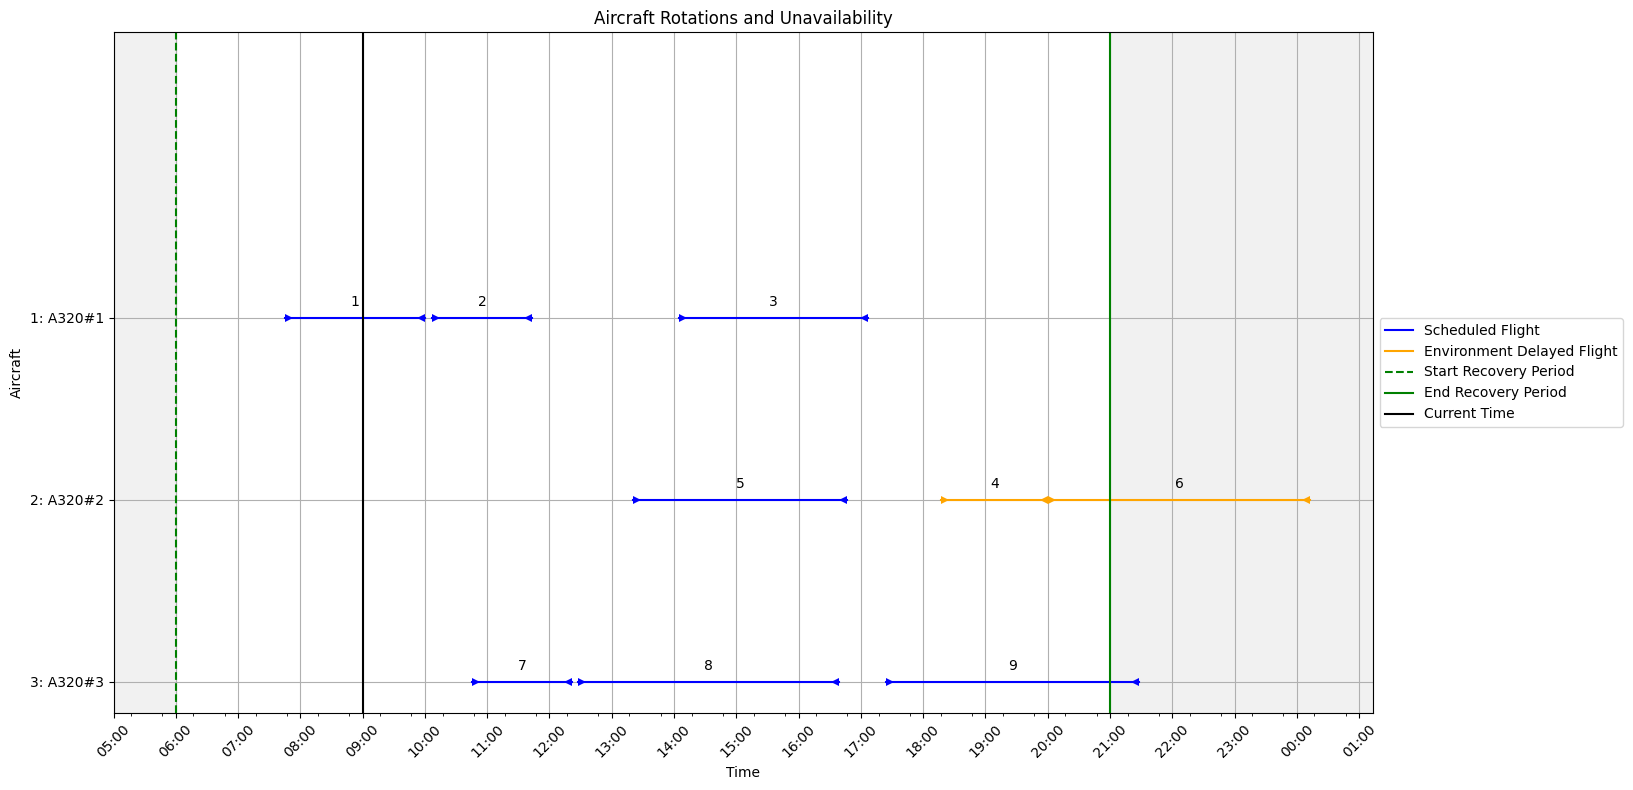

[[2 5 180 720 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan]
 [1 nan nan 0 nan 1 105 240 2 247 343 3 485 667 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [2 23 737 0 nan 5 440 647 4 737 840 6 840 1093 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]
 [3 nan nan 0 nan 7 285 382 8 387 639 9 684 928 nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan]]

Processed action: 3 of type: <class 'numpy.int64'>
Current conflicts: {('A320#2', 440.0, 647.0)}
Cancelled flights: set()
Updating flight times for flight 9.0
 - previous times: 17:24 21:28
 - new times: 20:06 00:10
Updating flight times for flight 9.0
 - previous times: 20:06 00:10
 - new times: 20:06 00:10
Updating flight times for flight 5.0
 

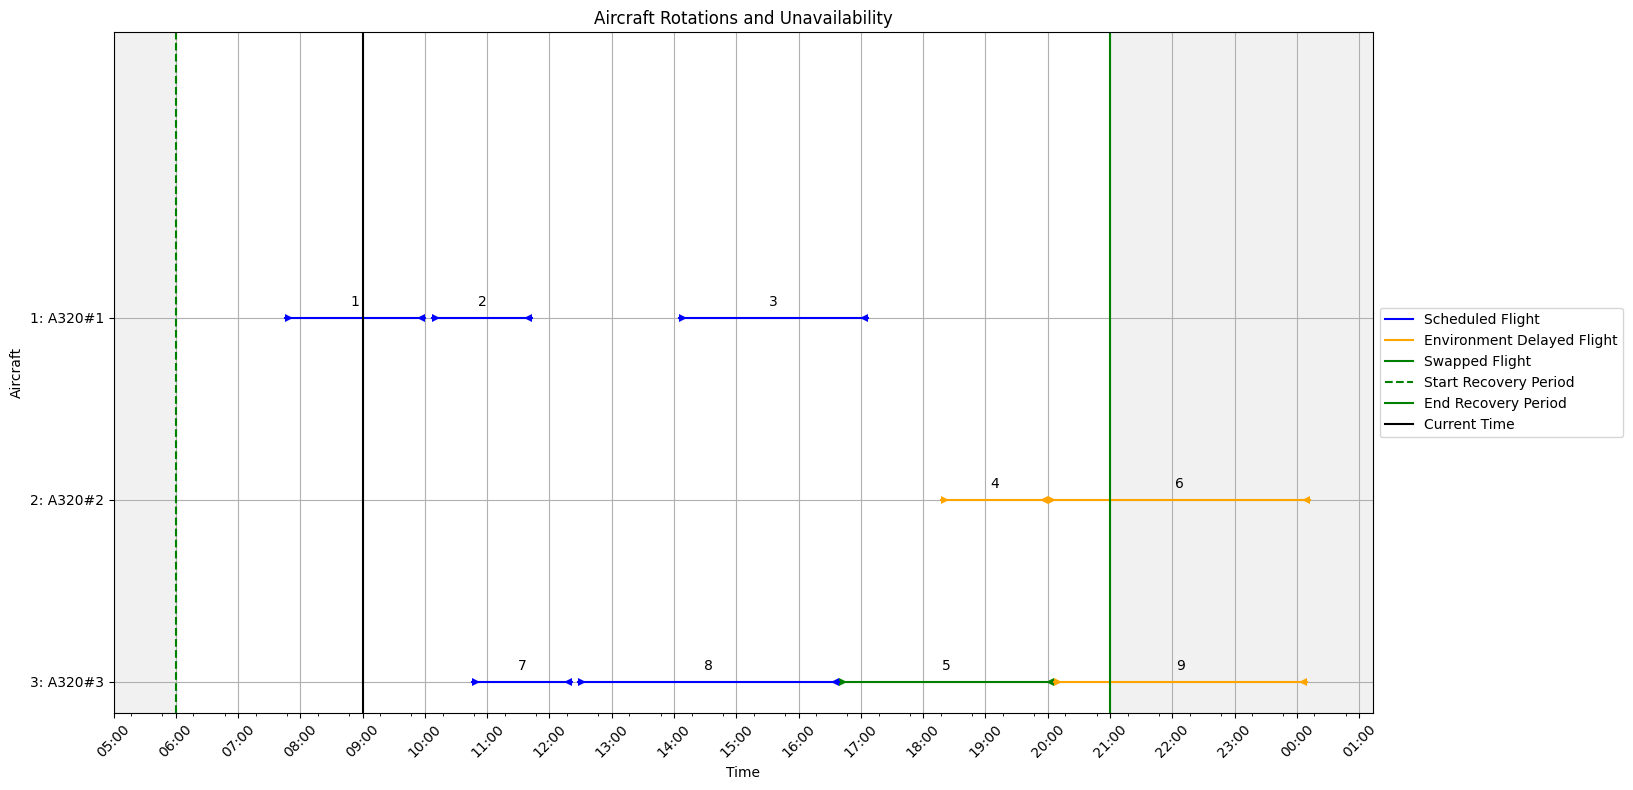

Total Reward: -2992.0


In [1]:
import os
import numpy as np
import gymnasium as gym
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt
from scripts.utils import *
from scripts.visualizations import *
from src.config import *
from datetime import datetime, timedelta
from src.environment import AircraftDisruptionEnv
from scripts.visualizations import StatePlotter

# Run the random agent
def run_random_agent(scenario_folder):
    # Load the scenario data
    data_dict = load_scenario_data(scenario_folder)

    # Extract necessary data for the environment
    aircraft_dict = data_dict['aircraft']
    flights_dict = data_dict['flights']
    rotations_dict = data_dict['rotations']
    alt_aircraft_dict = data_dict['alt_aircraft']
    config_dict = data_dict['config']

    # Initialize the environment
    env = AircraftDisruptionEnv(aircraft_dict, flights_dict, rotations_dict, alt_aircraft_dict, config_dict)
    env = DummyVecEnv([lambda: env])

    # Reset the environment
    obs = env.reset()
    print("Observation shape:", obs.shape)

    done = False
    total_reward = 0
    step_num = 0

    # Create StatePlotter object for visualizing the environment state
    state_plotter = StatePlotter(
        aircraft_dict=aircraft_dict,
        flights_dict=flights_dict,
        rotations_dict=rotations_dict,
        alt_aircraft_dict=alt_aircraft_dict,  # Initial alt_aircraft_dict
        start_datetime=env.get_attr('start_datetime')[0],
        end_datetime=env.get_attr('end_datetime')[0]
    )

    while not done:
        # Visualize the environment at each step
        print(f"Step {step_num}:")

        # Extract necessary information from the environment for plotting
        swapped_flights = env.get_attr('swapped_flights')[0]
        environment_delayed_flights = env.get_attr('environment_delayed_flights')[0]
        current_datetime = env.get_attr('current_datetime')[0]

        # Retrieve the updated flights_dict from the environment
        updated_flights_dict = env.get_attr('flights_dict')[0]
        cancelled_flights = env.get_attr('penalized_cancelled_flights')[0]

        # Retrieve the updated alt_aircraft_dict from the environment
        updated_alt_aircraft_dict = env.get_attr('alt_aircraft_dict')[0]

        if DEBUG_MODE_VISUALIZATION:
            print("Flights Dict:")
            print(updated_flights_dict)
            print("Alt Aircraft Dict:")
            print(updated_alt_aircraft_dict)
            print("Swapped Flights:")
            print(swapped_flights)
            print("Environment Delayed Flights:")
            print(environment_delayed_flights)
            print("Cancelled Flights:")
            print(cancelled_flights)
            print("Unavailabilities:")
            print(env.get_attr('alt_aircraft_dict')[0])
            print("Uncertain Breakdowns:")
            for key, value in env.get_attr('uncertain_breakdowns')[0].items():
                print(f"{key}: {value}")
            print("Current Breakdowns:")
            print(env.get_attr('current_breakdowns')[0])
            print("")
        # Update the StatePlotter's alt_aircraft_dict
        state_plotter.alt_aircraft_dict = updated_alt_aircraft_dict

        # Plot the state using the updated alt_aircraft_dict
        state_plotter.plot_state(
            updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
        )

        # Sample a random action
        action = np.random.randint(0, env.action_space.n, size=env.num_envs)
        # action = [0]  # Always no action

        # Step the environment
        obs, rewards, dones, infos = env.step(action)

        # Extract values from arrays
        reward = rewards[0]
        done = dones[0]

        # Accumulate the reward
        total_reward += reward

        # print(f"Action taken: {action}, Reward: {reward}")
        print("")

        step_num += 1

    # Final plot after the simulation ends
    state_plotter.plot_state(
        updated_flights_dict, swapped_flights, environment_delayed_flights, cancelled_flights, current_datetime
    )

    print(f"Total Reward: {total_reward}")

SCENARIO_FOLDER = "../Data/Testing/1k-3ac-12f-1dis-F/Scenario_01"
# SCENARIO_FOLDER = "../data/Example/Busy-scenario"

# Verify folder exists
if not os.path.exists(SCENARIO_FOLDER):
    raise FileNotFoundError(f"Scenario folder not found: {SCENARIO_FOLDER}")

# Run the random agent
run_random_agent(SCENARIO_FOLDER)
